In [86]:
# imports and defines
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from itertools import product

DATA_PATH = "Data/" # path to folder with data

In [87]:
# Loading dataset with BTC prices.
btc_price = pd.read_csv(DATA_PATH + 'BTC_data.csv', low_memory = False)
btc_price['timestamp'] = pd.to_datetime(btc_price['timestamp']).dt.tz_localize(None)
print(btc_price.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        720 non-null    datetime64[ns]
 1   price            720 non-null    float64       
 2   returns          720 non-null    float64       
 3   squared_returns  720 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 22.6 KB
None


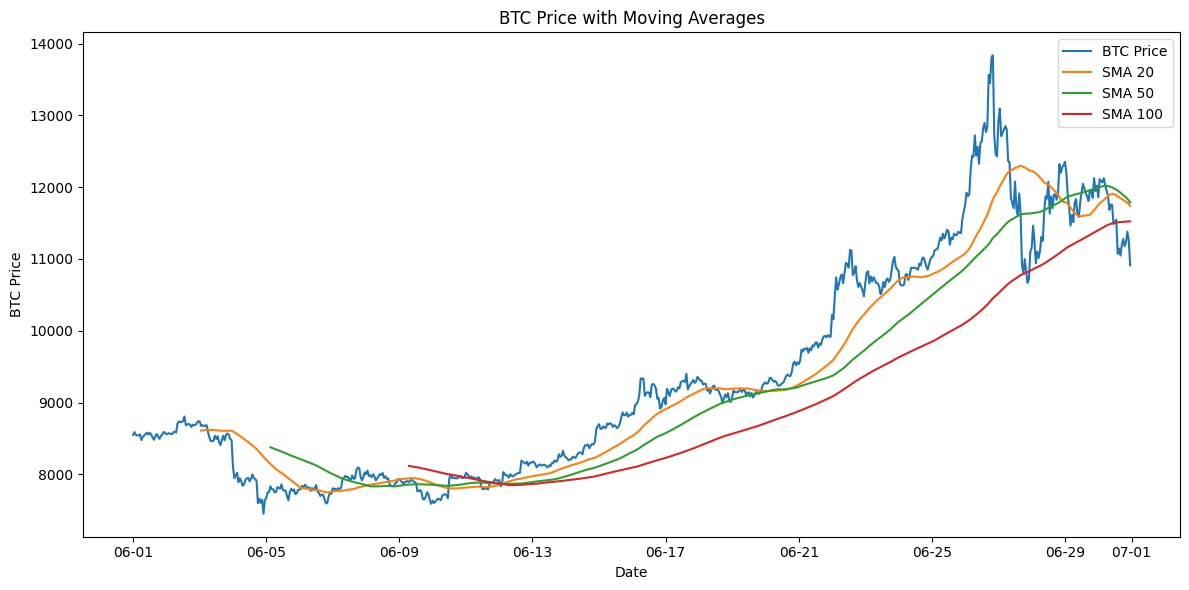

In [88]:
# Moving average chart for Bitcoin

sma50 = btc_price.price.rolling(50).mean()
sma100 = btc_price.price.rolling(100).mean()
sma200 = btc_price.price.rolling(200).mean()

fig, ax = plt.subplots(figsize=(12, 6))

ax.set_xlabel('Date')
ax.set_ylabel('BTC Price')
ax.plot(btc_price.timestamp, btc_price.price, label="BTC Price")
ax.plot(btc_price.timestamp, sma50, label="SMA 20")
ax.plot(btc_price.timestamp, sma100, label="SMA 50")
ax.plot(btc_price.timestamp, sma200, label="SMA 100")
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.title("BTC Price with Moving Averages")
plt.tight_layout()
plt.legend()
plt.show()


In [89]:
# Checking stanionarity of the data

# Function to perform ADF test
def adf_test(timeseries):
    result = adfuller(timeseries)
    if result[1] <= 0.05:
        return True  # Stationary
    else:
        return False  # Non-stationary

# Check if price is stationary
is_stationary = adf_test(btc_price['price'])

# If not stationary, difference and check again
d = 0
while not is_stationary:
    d += 1
    btc_price['price_diff'] = btc_price['price'].diff(periods=d).dropna()
    is_stationary = adf_test(btc_price['price_diff'].dropna())

print(f"Optimal value of d: {d}")

Optimal value of d: 1


<Figure size 600x400 with 0 Axes>

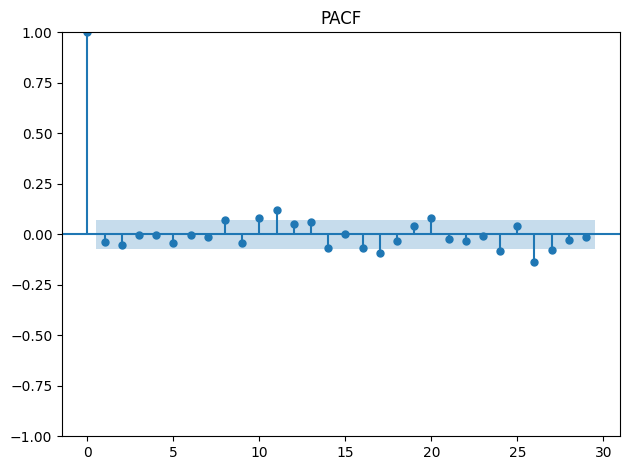

<Figure size 600x400 with 0 Axes>

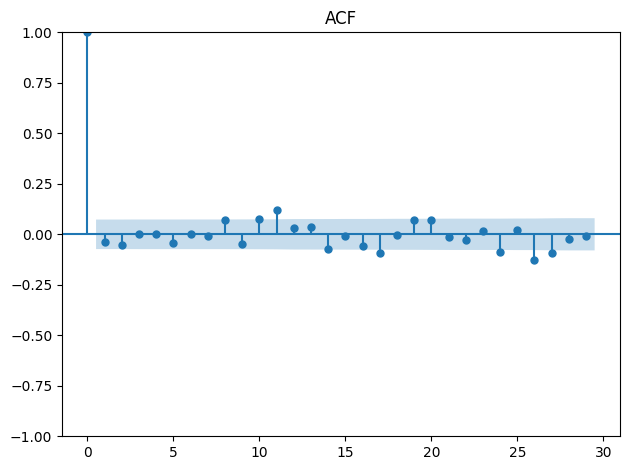

In [90]:
# Plot PACF for squared returns
plt.figure(figsize=(6, 4)) 
plot_pacf(btc_price['returns'].dropna(), title="PACF")  # p value
plt.tight_layout()
plt.show()

# Plot ACF for squared returns
plt.figure(figsize=(6, 4))
plot_acf(btc_price['returns'].dropna(), title="ACF")  # q value
plt.tight_layout()
plt.show()

In [91]:
# FIT ARIMA(1,1,0)
model = ARIMA(btc_price['returns'], order=(1,1,0)) # (p,d,q)
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                  720
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1220.982
Date:                Sun, 10 Dec 2023   AIC                           2445.964
Time:                        00:55:27   BIC                           2455.120
Sample:                             0   HQIC                          2449.499
                                - 720                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4938      0.021    -23.390      0.000      -0.535      -0.452
sigma2         1.7473      0.047     36.990      0.000       1.655       1.840
===================================================================================
Ljung-Box (L1) (Q):                  22.91   Jarque-Bera (JB):              1419.16
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.30   Skew:                            -0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [92]:
# FIT ARIMA(1,1,1)
model = ARIMA(btc_price['returns'], order=(1,1,1)) # (p,d,q)
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                  720
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1063.237
Date:                Sun, 10 Dec 2023   AIC                           2132.474
Time:                        00:55:27   BIC                           2146.208
Sample:                             0   HQIC                          2137.776
                                - 720                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0385      0.027     -1.418      0.156      -0.092       0.015
ma.L1         -0.9991      0.007   -137.315      0.000      -1.013      -0.985
sigma2         1.1176      0.029     38.441      0.000       1.061       1.175
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2945.67
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               4.19   Skew:                            -0.90
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

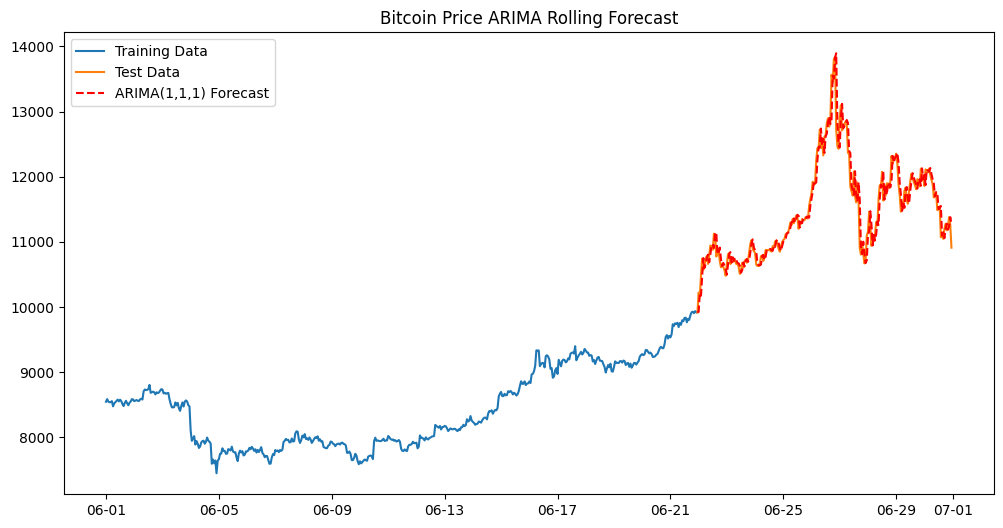

Mean Squared Error: 38254.39
Root Mean Squared Error: 195.59
Mean Absolute Percentage Error: 1.14


In [93]:
# ARIMA model

train_size = int(len(btc_price) * 0.7)
train, test = btc_price['returns'][0:train_size], btc_price['returns'][train_size:]
train_price, test_price = btc_price['price'][0:train_size], btc_price['price'][train_size:]

history = [x for x in train]
predictions = []

# Rolling forecast
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1)) # (p,d,q)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=1)
    predictions.append(forecast[0])
    history.append(test.iloc[t])  # Add actual observation to history for the next iteration

# Convert the predicted returns to price levels
predicted_prices = []
for idx, predicted_return in enumerate(predictions):
    actual_price = test_price.iloc[idx-1] if idx > 0 else train_price.iloc[-1] # Use the last actual price
    predicted_prices.append(actual_price * (1 + predicted_return/100))

# Plots
plt.figure(figsize=(12, 6))
plt.plot(btc_price.timestamp[:train_size], train_price, label='Training Data')
plt.plot(btc_price.timestamp[train_size:], test_price, label='Test Data')
plt.plot(btc_price.timestamp[train_size:], predicted_prices, label='ARIMA(1,1,1) Forecast', color='red', linestyle='--')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.legend(loc='upper left')
plt.title("Bitcoin Price ARIMA Rolling Forecast")
plt.show()

# Calculate MSE
mse = round(mean_squared_error(test_price, predicted_prices), 2)
print('Mean Squared Error:', mse)

# Calculate RMSE
rmse = round(np.sqrt(mse), 2)
print('Root Mean Squared Error:', rmse)

# Calculate MAPE
mape = round(np.mean(np.abs((test_price - predicted_prices) / test_price)) * 100, 2)
print('Mean Absolute Percentage Error:', mape)


Trading strategy:
- Long: If ARIMA predicts a higher closing price than the current close value.
- Short:  If ARIMA predicts a lower closing price than the current close value.
- Neutral: If the prediction is within a threshold.

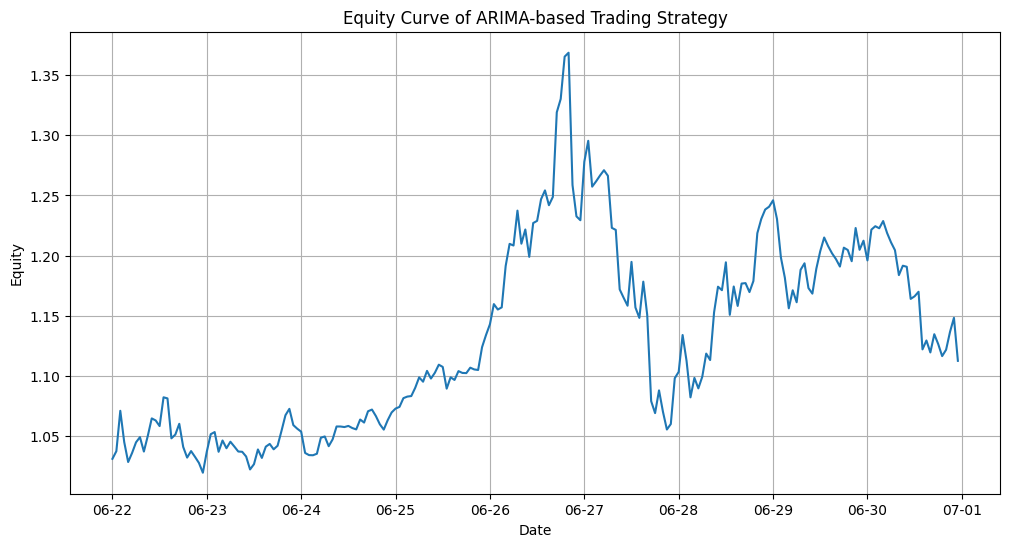

In [94]:
# Simple trading strategy test

signals = [0]  # start with no action
for i in range(1, len(predicted_prices)):
    if predicted_prices[i] > test_price.iloc[i-1]:  # predict higher close
        signals.append(1)  # long
    elif predicted_prices[i] < test_price.iloc[i-1]:  # predict lower close
        signals.append(-1)  # short
    else:  # if the direction is the same as the previous day
        signals.append(0)  # no action

returns = test_price.pct_change().dropna()  # daily returns
strategy_returns = signals[1:] * returns  # align with the shifted signal

equity_curve = (1 + strategy_returns).cumprod()

# Plot
plt.figure(figsize=(12,6))
plt.plot(btc_price.timestamp[train_size+1:], equity_curve)
plt.title('Equity Curve of ARIMA-based Trading Strategy')
plt.xlabel('Date')
plt.ylabel('Equity')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.grid(True)
plt.show()